### Perform 1st and 2nd Order LASSO on rates and data from model 0

In [17]:
import os, sys
import time
import csv
import tqdm.notebook as tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.optimize import curve_fit
from sklearn import linear_model
from sklearn.decomposition import PCA
import warnings
from sklearn.exceptions import ConvergenceWarning

from mgsa.io import samples_from_soils, get_function, get_data
from mgsa.modeling import Model
from mgsa.helpers import plot

### First load in X (variants) and Y (targets) for CHL +/-

In [5]:
NARG_INFO = {
    "KO": "K00370",
    "ORF_GROUPS_FPATH": "../out/groups/assignments_K00370_v1.tsv"
}

NIRB_INFO = {
    "KO": "K00362",
    "ORF_GROUPS_FPATH": "../out/groups/assignments_K00362_v1.tsv"
}

NATIVE_IDXS = [2, 4, 5, 8, 10, 11, 13, 14, 15, 16]
NATIVE_PHS = np.array([5.0, 5.3, 5.41, 5.8, 6.15, 6.3, 6.5, 6.75, 6.9,  7.1])
PERTURBED_PHS = np.linspace(3.8, 8.4, 11)

OUTDIR = "../out/model_regression/nar"
IMGDIR = f"{OUTDIR}/images"
os.makedirs(OUTDIR, exist_ok=True)
os.makedirs(IMGDIR, exist_ok=True)

def texify(param_name):
    return {
        "gamma_A": "\\gamma_{{A}}", 
        "gamma_I": "\\gamma_{{I}}", 
        "r_A": "r_{{A}}", 
        "r_I1": "r_{{I1}}", 
        "r_I2": "r_{{I2}}", 
        "K_A": "K_{{A}}", 
        "K_I": "K_{{I}}", 
        "mu": "\\mu", 
    }[param_name]

t_data_drug = np.linspace(0, 19, 20)

soils = [
    'Soil3', 'Soil5', 'Soil6', 'Soil9', 'Soil11', 
    'Soil12', 'Soil14', 'Soil15', 'Soil16', 'Soil17'
]



def load_orf_groups(fpath) -> tuple[dict[int:str], np.ndarray[int]]:
    groups = {}
    idxs = []
    with open(fpath, "r") as f:
        csvreader = csv.reader(f, delimiter=" ")
        for row in csvreader:  # process each row
            orf = row[0]
            gidx = int(row[1])
            if gidx in groups:
                groups[gidx].append(orf)
            else:
                groups[gidx] = [orf]
                idxs.append(gidx)
    return groups, np.sort(idxs)

##############################################################################
##  Collect narG data

# Load ORF groups for narG
groups, group_idxs = load_orf_groups(NARG_INFO["ORF_GROUPS_FPATH"])
total = 0
for gidx in group_idxs:
    group = groups[gidx]
    n = len(group)
    print(f"Group {gidx}: {n} ORFs")
    total += n
print(f"  Total: {total}")

# Aggregate T0 and T9 expression data in the CHL+ and CHL- conditions
gidx2exp_chl_pos_t0 = {gidx: [] for gidx in group_idxs}
gidx2exp_chl_pos_t9 = {gidx: [] for gidx in group_idxs}
gidx2exp_chl_neg_t0 = {gidx: [] for gidx in group_idxs}
gidx2exp_chl_neg_t9 = {gidx: [] for gidx in group_idxs}
for gidx in group_idxs:
    group = groups[gidx]
    for i, orf in enumerate(group):
        data_chl_pos_t0, data_chl_pos_t9 = get_data(
            orf, 
            DATDIR='../out', 
            KO=NARG_INFO["KO"], 
            drug='CHL', 
            map='09',
        )
        data_chl_neg_t0, data_chl_neg_t9 = get_data(
            orf, 
            DATDIR='../out', 
            KO=NARG_INFO["KO"], 
            drug='None', 
            map='09',
        )
        # Subset T0 samples to those of interest
        data_chl_pos_t0 = data_chl_pos_t0[NATIVE_IDXS]
        data_chl_neg_t0 = data_chl_neg_t0[NATIVE_IDXS]

        gidx2exp_chl_pos_t0[gidx].append(data_chl_pos_t0)
        gidx2exp_chl_pos_t9[gidx].append(data_chl_pos_t9)
        gidx2exp_chl_neg_t0[gidx].append(data_chl_neg_t0)
        gidx2exp_chl_neg_t9[gidx].append(data_chl_neg_t9)

    # Sum the expression data in each group
    gidx2exp_chl_pos_t0[gidx] = np.sum(gidx2exp_chl_pos_t0[gidx], axis=0)
    gidx2exp_chl_pos_t9[gidx] = np.sum(gidx2exp_chl_pos_t9[gidx], axis=0)
    gidx2exp_chl_neg_t0[gidx] = np.sum(gidx2exp_chl_neg_t0[gidx], axis=0)
    gidx2exp_chl_neg_t9[gidx] = np.sum(gidx2exp_chl_neg_t9[gidx], axis=0)

# Check lengths are correct
for gidx in group_idxs:
    assert gidx2exp_chl_pos_t0[gidx].shape == (10,), "Wrong shape for t0 pos"
    assert gidx2exp_chl_pos_t9[gidx].shape == (10,11), "Wrong shape for t9 pos"
    assert gidx2exp_chl_neg_t0[gidx].shape == (10,), "Wrong shape for t0 neg"
    assert gidx2exp_chl_neg_t9[gidx].shape == (10,11), "Wrong shape for t9 neg"

# Construct arrays of aggregated soil expression levels. The last axis 
# corresponds to the groups.
nar_exp_chl_pos_t0 = np.zeros([10, len(group_idxs)])
nar_exp_chl_pos_t9 = np.zeros([10, 11, len(group_idxs)])
nar_exp_chl_neg_t0 = np.zeros([10, len(group_idxs)])
nar_exp_chl_neg_t9 = np.zeros([10, 11, len(group_idxs)])
for i, gidx in enumerate(group_idxs):
    nar_exp_chl_pos_t0[...,i] = gidx2exp_chl_pos_t0[gidx]
    nar_exp_chl_pos_t9[...,i] = gidx2exp_chl_pos_t9[gidx]
    nar_exp_chl_neg_t0[...,i] = gidx2exp_chl_neg_t0[gidx]
    nar_exp_chl_neg_t9[...,i] = gidx2exp_chl_neg_t9[gidx]

##############################################################################
##  Collect nirB data

# Load ORF groups for nirB
groups, group_idxs = load_orf_groups(NIRB_INFO["ORF_GROUPS_FPATH"])
total = 0
for gidx in group_idxs:
    group = groups[gidx]
    n = len(group)
    print(f"Group {gidx}: {n} ORFs")
    total += n
print(f"  Total: {total}")

# Aggregate T0 and T9 expression data in the CHL+ and CHL- conditions
gidx2exp_chl_pos_t0 = {gidx: [] for gidx in group_idxs}
gidx2exp_chl_pos_t9 = {gidx: [] for gidx in group_idxs}
gidx2exp_chl_neg_t0 = {gidx: [] for gidx in group_idxs}
gidx2exp_chl_neg_t9 = {gidx: [] for gidx in group_idxs}
for gidx in group_idxs:
    group = groups[gidx]
    for i, orf in enumerate(group):
        data_chl_pos_t0, data_chl_pos_t9 = get_data(
            orf, 
            DATDIR='../out', 
            KO=NIRB_INFO["KO"], 
            drug='CHL', 
            map='09',
        )
        data_chl_neg_t0, data_chl_neg_t9 = get_data(
            orf, 
            DATDIR='../out', 
            KO=NIRB_INFO["KO"], 
            drug='None', 
            map='09',
        )
        # Subset T0 samples to those of interest
        data_chl_pos_t0 = data_chl_pos_t0[NATIVE_IDXS]
        data_chl_neg_t0 = data_chl_neg_t0[NATIVE_IDXS]

        gidx2exp_chl_pos_t0[gidx].append(data_chl_pos_t0)
        gidx2exp_chl_pos_t9[gidx].append(data_chl_pos_t9)
        gidx2exp_chl_neg_t0[gidx].append(data_chl_neg_t0)
        gidx2exp_chl_neg_t9[gidx].append(data_chl_neg_t9)

    # Sum the expression data in each group
    gidx2exp_chl_pos_t0[gidx] = np.sum(gidx2exp_chl_pos_t0[gidx], axis=0)
    gidx2exp_chl_pos_t9[gidx] = np.sum(gidx2exp_chl_pos_t9[gidx], axis=0)
    gidx2exp_chl_neg_t0[gidx] = np.sum(gidx2exp_chl_neg_t0[gidx], axis=0)
    gidx2exp_chl_neg_t9[gidx] = np.sum(gidx2exp_chl_neg_t9[gidx], axis=0)

# Check lengths are correct
for gidx in group_idxs:
    assert gidx2exp_chl_pos_t0[gidx].shape == (10,), "Wrong shape for t0 pos"
    assert gidx2exp_chl_pos_t9[gidx].shape == (10,11), "Wrong shape for t9 pos"
    assert gidx2exp_chl_neg_t0[gidx].shape == (10,), "Wrong shape for t0 neg"
    assert gidx2exp_chl_neg_t9[gidx].shape == (10,11), "Wrong shape for t9 neg"

# Construct arrays of aggregated soil expression levels. The last axis 
# corresponds to the groups.
nir_exp_chl_pos_t0 = np.zeros([10, len(group_idxs)])
nir_exp_chl_pos_t9 = np.zeros([10, 11, len(group_idxs)])
nir_exp_chl_neg_t0 = np.zeros([10, len(group_idxs)])
nir_exp_chl_neg_t9 = np.zeros([10, 11, len(group_idxs)])
for i, gidx in enumerate(group_idxs):
    nir_exp_chl_pos_t0[...,i] = gidx2exp_chl_pos_t0[gidx]
    nir_exp_chl_pos_t9[...,i] = gidx2exp_chl_pos_t9[gidx]
    nir_exp_chl_neg_t0[...,i] = gidx2exp_chl_neg_t0[gidx]
    nir_exp_chl_neg_t9[...,i] = gidx2exp_chl_neg_t9[gidx]


Group 1: 14 ORFs
Group 2: 4 ORFs
Group 3: 4 ORFs
Group 4: 8 ORFs
Group 5: 6 ORFs
Group 6: 6 ORFs
Group 7: 15 ORFs
  Total: 57
Group 1: 6 ORFs
Group 2: 19 ORFs
Group 3: 8 ORFs
Group 4: 6 ORFs
Group 5: 10 ORFs
Group 6: 7 ORFs
Group 7: 6 ORFs
  Total: 62


In [ ]:
##############################################################################
##  Normalize narG expression levels
nar_rel_exp_chl_pos_t0 = nar_exp_chl_pos_t0 / np.sum(nar_exp_chl_pos_t0, -1)[...,None]
nar_rel_exp_chl_pos_t0 = nar_rel_exp_chl_pos_t0[:, np.newaxis, :]
nar_rel_exp_chl_pos_t0 = np.broadcast_to(nar_rel_exp_chl_pos_t0, (10, 11, 7))

##############################################################################
##  Normalize nirB expression levels
nir_rel_exp_chl_pos_t0 = nir_exp_chl_pos_t0 / np.sum(nir_exp_chl_pos_t0, -1)[...,None]
nir_rel_exp_chl_pos_t0 = nir_rel_exp_chl_pos_t0[:, np.newaxis, :]
nir_rel_exp_chl_pos_t0 = np.broadcast_to(nir_rel_exp_chl_pos_t0, (10, 11, 7))

##############################################################################
##  Normalize narG expression levels
nar_rel_exp_chl_neg_t0 = nar_exp_chl_neg_t0 / np.sum(nar_exp_chl_neg_t0, -1)[...,None]
nar_rel_exp_chl_neg_t0 = nar_rel_exp_chl_neg_t0[:, np.newaxis, :]
nar_rel_exp_chl_neg_t0 = np.broadcast_to(nar_rel_exp_chl_neg_t0, (10, 11, 7))

##############################################################################
##  Normalize nirB expression levels
nir_rel_exp_chl_neg_t0 = nir_exp_chl_neg_t0 / np.sum(nir_exp_chl_neg_t0, -1)[...,None]
nir_rel_exp_chl_neg_t0 = nir_rel_exp_chl_neg_t0[:, np.newaxis, :]
nir_rel_exp_chl_neg_t0 = np.broadcast_to(nir_rel_exp_chl_neg_t0, (10, 11, 7))

##############################################################################
##  Normalize narG expression levels

nar_rel_exp_chl_neg_t9 = nar_exp_chl_neg_t9 / np.sum(nar_exp_chl_neg_t9, -1)[...,None]

##############################################################################
##  Normalize nirB expression levels
nir_rel_exp_chl_neg_t9 = nir_exp_chl_neg_t9 / np.sum(nir_exp_chl_neg_t9, -1)[...,None]

X_NAR_CHL_POS = nar_rel_exp_chl_pos_t0
X_NIR_CHL_POS = nir_rel_exp_chl_pos_t0
X_NAR_CHL_NEG = np.concatenate([nar_rel_exp_chl_neg_t0, nar_rel_exp_chl_neg_t9], axis = -1)
X_NIR_CHL_NEG = np.concatenate([nir_rel_exp_chl_neg_t0, nir_rel_exp_chl_neg_t9], axis = -1)

(10, 11, 7)


### Collect Metabolic Parameters (Target for Regression)

In [28]:
rA_chl_pos = pd.read_csv('../out/metabolic_parameters/rA_model0_chl_pos.tsv', sep = '\t', header = None).values
rI_chl_pos = pd.read_csv('../out/metabolic_parameters/rI_model0_chl_pos.tsv', sep = '\t', header = None).values
rA_chl_neg = pd.read_csv('../out/metabolic_parameters/rA_model0_chl_neg.tsv', sep = '\t', header = None).values
rI_chl_neg = pd.read_csv('../out/metabolic_parameters/rI_model0_chl_neg.tsv', sep = '\t', header = None).values

Y_CHL_POS = np.concatenate([rA_chl_pos[..., np.newaxis], rI_chl_pos[..., np.newaxis]], axis = -1)
Y_CHL_NEG = np.concatenate([rA_chl_neg[..., np.newaxis], rI_chl_neg[..., np.newaxis]], axis = -1)

### Perform 1st order LASSO on CHL+ data

And do that per column (fixed pH sets)

In [29]:
##############################################################################
### Lasso for NAR, NIR CHL+ case

ALPHA = 0.0025  # Regularization strength

clf_nar = []
clf_nir = []
for i in range(11):
    clf = linear_model.Lasso(alpha=ALPHA)
    clf.fit(X_NAR_CHL_POS[:,i,:], Y_CHL_POS[:,i,0])
    clf_nar.append(clf)
    clf = linear_model.Lasso(alpha=ALPHA)
    clf.fit(X_NIR_CHL_POS[:,i,:], Y_CHL_POS[:,i,1])
    clf_nir.append(clf)

print("--------------------------------------------------")
print("NAR")
for i in range(11):
    print(f"Coefficients {clf_nar[i].coef_.shape}:\n", clf_nar[i].coef_)
    print(f"Intercepts: {clf_nar[i].intercept_.shape}\n", clf_nar[i].intercept_)
print("--------------------------------------------------")

print("--------------------------------------------------")
print("NIR")
for i in range(11):
    print(f"Coefficients {clf_nir[i].coef_.shape}:\n", clf_nir[i].coef_)
    print(f"Intercepts: {clf_nir[i].intercept_.shape}\n", clf_nir[i].intercept_)
print("--------------------------------------------------")


--------------------------------------------------
NAR
Coefficients (7,):
 [ 2.29667223e+00  0.00000000e+00 -0.00000000e+00  1.93269990e-04
  0.00000000e+00  0.00000000e+00 -6.56333253e-02]
Intercepts: ()
 0.07775391337947779
Coefficients (7,):
 [ 2.78471778  0.          0.          0.          0.          0.
 -0.48709624]
Intercepts: ()
 0.14058394782973682
Coefficients (7,):
 [ 1.31722728  0.         -0.         -0.          0.          0.
 -0.        ]
Intercepts: ()
 0.04849172590139583
Coefficients (7,):
 [ 1.01042374  0.          0.         -0.          0.          0.
 -0.06875318]
Intercepts: ()
 0.13412871141177474
Coefficients (7,):
 [ 0.65205978  0.         -0.          0.01241018  0.          0.
 -0.05885064]
Intercepts: ()
 0.18968542541895828
Coefficients (7,):
 [ 0.35932666  0.         -0.02744414  0.1700006   0.          0.
 -0.03351705]
Intercepts: ()
 0.2558909943742406
Coefficients (7,):
 [ 0.05618775  0.         -0.          0.25873268  0.          0.
 -0.132649  ]
I

### Collect LASSO-predicted rate parameters

In [30]:
rA_grid = np.zeros((10,11))
rI_grid = np.zeros((10,11))
X_NIR = nir_rel_exp_chl_pos_t0
X_NAR = nar_rel_exp_chl_pos_t0
for native in tqdm.trange(10, desc="native", leave=False):
        for pert in tqdm.trange(11, desc="perturbed", leave=False):
            rA_pred = 0
            rI_pred = 0
            for i in range(len(group_idxs)):
                rA_pred += X_NAR[native, pert, i]*clf_nar[pert].coef_[i]
                rI_pred += X_NIR[native, pert, i]*clf_nir[pert].coef_[i]  
            rA_pred += clf_nar[pert].intercept_
            rI_pred += clf_nir[pert].intercept_
            y_pred = [rA_pred, rI_pred]
            rA_grid[native, pert] = rA_pred
            rI_grid[native, pert] = rI_pred


native:   0%|          | 0/10 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

### Make a plot comparing predicted to fitted rA and rI

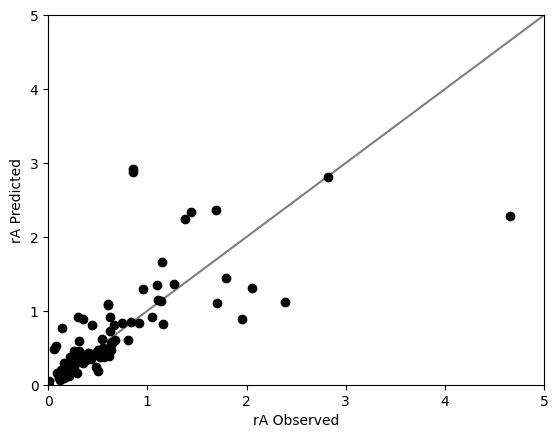

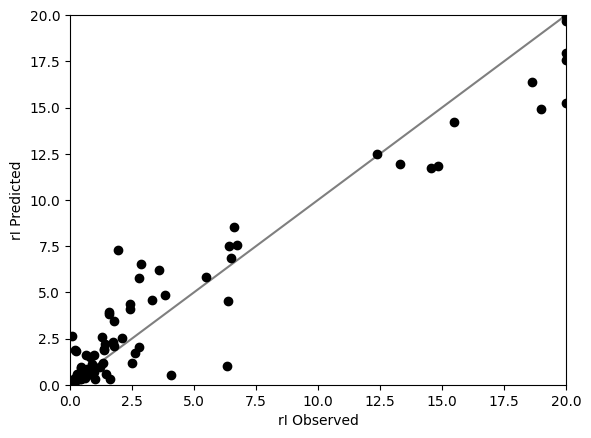

In [ ]:

x_nar = np.zeros(110)
y_nar = np.zeros(110)
x_nir = np.zeros(110)
y_nir = np.zeros(110)
x = np.linspace(0,20,10)
y = np.linspace(0,20,10)
for native in range(10):
    for pert in range(11):
        x_nar[10*native + pert] = Y_CHL_POS[native,pert, 0]
        x_nir[10*native + pert] = Y_CHL_POS[native,pert, 1]
        y_nar[10*native + pert] = rA_grid[native, pert]
        y_nir[10*native + pert] = rI_grid[native, pert]
        
plt.scatter(x_nar, y_nar, color = 'Black')
plt.plot(x,y, color = 'Black', alpha = 0.5)
plt.xlabel('rA Observed')
plt.ylabel('rA Predicted')
plt.title('CHL_ LASSO prediction rA')
plt.xlim(0,5)
plt.ylim(0,5)
plt.show()
plt.scatter(x_nir, y_nir, color = 'Black')
plt.plot(x,y, color = 'Black', alpha = 0.5)
plt.xlabel('rI Observed')
plt.ylabel('rI Predicted')
plt.title('CHL+ LASSO prediction rI')
plt.xlim(0,20)
plt.ylim(0,20)
plt.show()


### Perform first order LASSO on CHL - data

In [55]:
##############################################################################
### Lasso for NAR, NIR CHL+ case

ALPHA = 0.0025  # Regularization strength

clf_nar = []
clf_nir = []
for i in range(11):
    clf = linear_model.Lasso(alpha=ALPHA)
    clf.fit(X_NAR_CHL_NEG[:,i,:], Y_CHL_NEG[:,i,0])
    clf_nar.append(clf)
    clf = linear_model.Lasso(alpha=ALPHA)
    clf.fit(X_NIR_CHL_NEG[:,i,:], Y_CHL_NEG[:,i,1])
    clf_nir.append(clf)

print("--------------------------------------------------")
print("NAR")
for i in range(11):
    print(f"Coefficients {clf_nar[i].coef_.shape}:\n", clf_nar[i].coef_)
    print(f"Intercepts: {clf_nar[i].intercept_.shape}\n", clf_nar[i].intercept_)
print("--------------------------------------------------")

print("--------------------------------------------------")
print("NIR")
for i in range(11):
    print(f"Coefficients {clf_nir[i].coef_.shape}:\n", clf_nir[i].coef_)
    print(f"Intercepts: {clf_nir[i].intercept_.shape}\n", clf_nir[i].intercept_)
print("--------------------------------------------------")


--------------------------------------------------
NAR
Coefficients (14,):
 [ 0.77187759  0.         -0.69665286  0.19748231  0.          0.
 -0.         -0.          0.          0.         -0.          0.52575097
  0.         -0.31288342]
Intercepts: ()
 0.32120182905372463
Coefficients (14,):
 [ 0.63649461  0.         -0.         -0.          0.          0.
 -0.          0.13318919 -0.         -0.         -0.         -0.
 -0.          0.        ]
Intercepts: ()
 0.09965023981621818
Coefficients (14,):
 [ 0.77015763  0.         -0.12650079  0.02522603  0.          0.
 -0.          0.08207316  0.          0.          0.62314287 -0.19672774
 -0.         -0.        ]
Intercepts: ()
 0.06755900730559816
Coefficients (14,):
 [ 0.38670444  0.         -0.          0.          0.          0.
 -0.34803546  0.12897876 -0.         -0.          0.22947234 -0.
 -0.46825514 -0.        ]
Intercepts: ()
 0.32059800910532454
Coefficients (14,):
 [ 0.06633109  0.         -0.          0.22168173  0.    

/Users/joelandsittel/Documents/soil/env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.987e-02, tolerance: 5.506e-02
  model = cd_fast.enet_coordinate_descent(
/Users/joelandsittel/Documents/soil/env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.413e-01, tolerance: 2.464e-02
  model = cd_fast.enet_coordinate_descent(


In [56]:
rA_grid = np.zeros((10,11))
rI_grid = np.zeros((10,11))
X_NIR_T0 = nir_rel_exp_chl_neg_t0
X_NAR_T0 = nar_rel_exp_chl_neg_t0
X_NIR_T9 = nir_rel_exp_chl_neg_t9
X_NAR_T9 = nar_rel_exp_chl_neg_t9
for native in tqdm.trange(10, desc="native", leave=False):
        for pert in tqdm.trange(11, desc="perturbed", leave=False):
            rA_pred = 0
            rI_pred = 0
            for i in range(len(group_idxs)):
                rA_pred += X_NAR_T0[native, pert, i]*clf_nar[pert].coef_[i]
                rI_pred += X_NIR_T0[native, pert, i]*clf_nir[pert].coef_[i]  
                rA_pred += X_NAR_T9[native, pert, i]*clf_nar[pert].coef_[i + len(group_idxs)]
                rI_pred += X_NIR_T9[native, pert, i]*clf_nir[pert].coef_[i + len(group_idxs)] 
            rA_pred += clf_nar[pert].intercept_
            rI_pred += clf_nir[pert].intercept_
            y_pred = [rA_pred, rI_pred]
            rA_grid[native, pert] = rA_pred
            rI_grid[native, pert] = rI_pred


native:   0%|          | 0/10 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

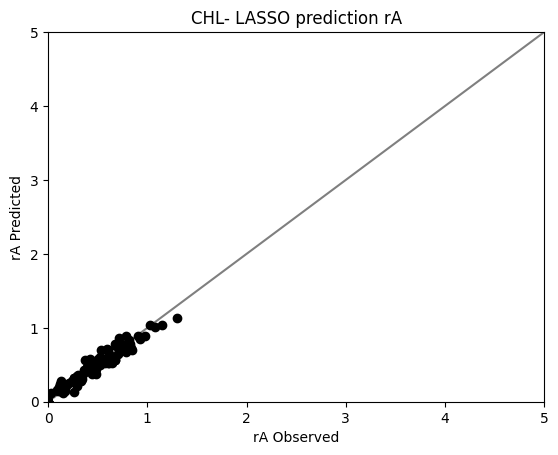

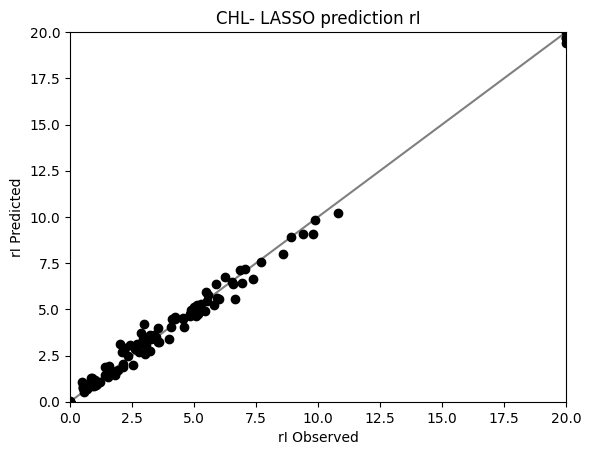

In [58]:

x_nar = np.zeros(110)
y_nar = np.zeros(110)
x_nir = np.zeros(110)
y_nir = np.zeros(110)
x = np.linspace(0,20,10)
y = np.linspace(0,20,10)
for native in range(10):
    for pert in range(11):
        x_nar[10*native + pert] = Y_CHL_NEG[native,pert, 0]
        x_nir[10*native + pert] = Y_CHL_NEG[native,pert, 1]
        y_nar[10*native + pert] = rA_grid[native, pert]
        y_nir[10*native + pert] = rI_grid[native, pert]
        
plt.scatter(x_nar, y_nar, color = 'Black')
plt.plot(x,y, color = 'Black', alpha = 0.5)
plt.xlabel('rA Observed')
plt.ylabel('rA Predicted')
plt.title('CHL- LASSO prediction rA')
plt.xlim(0,5)
plt.ylim(0,5)
plt.show()
plt.scatter(x_nir, y_nir, color = 'Black')
plt.plot(x,y, color = 'Black', alpha = 0.5)
plt.xlabel('rI Observed')
plt.ylabel('rI Predicted')
plt.title('CHL- LASSO prediction rI')
plt.xlim(0,20)
plt.ylim(0,20)
plt.show()


### Try to use a nonlinear (2nd order) model to find coefficients in the CHL- case

In [50]:
##############################################################################
### 2nd Order Polynomial Lasso for NAR, NIR CHL+ case

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

ALPHA = 0.025  # Regularization strength


poly = PolynomialFeatures(degree=2, include_bias=False)

clf_nar = []
clf_nir = []
for i in range(11):
    # Create pipeline: polynomial features -> Lasso
    pipeline = make_pipeline(poly, linear_model.Lasso(alpha=ALPHA))
    
    # Fit NAR model
    pipeline.fit(X_NAR_CHL_NEG[:,i,:], Y_CHL_NEG[:,i,0])
    clf_nar.append(pipeline)
    
    # Fit NIR model
    pipeline = make_pipeline(poly, linear_model.Lasso(alpha=ALPHA))
    pipeline.fit(X_NIR_CHL_NEG[:,i,:], Y_CHL_NEG[:,i,1])
    clf_nir.append(pipeline)

print("--------------------------------------------------")
print("NAR")
for i in range(11):
    # Get the Lasso model from the pipeline
    lasso_model = clf_nar[i].named_steps['lasso']
    print(f"Coefficients {lasso_model.coef_.shape}:\n", lasso_model.coef_)
    print(f"Intercepts: {lasso_model.intercept_.shape}\n", lasso_model.intercept_)
print("--------------------------------------------------")

print("--------------------------------------------------")
print("NIR")
for i in range(11):
    lasso_model = clf_nir[i].named_steps['lasso']
    print(f"Coefficients {lasso_model.coef_.shape}:\n", lasso_model.coef_)
    print(f"Intercepts: {lasso_model.intercept_.shape}\n", lasso_model.intercept_)
print("--------------------------------------------------")

# For prediction, we need to transform the input data with polynomial features first
rA_grid = np.zeros((10,11))
rI_grid = np.zeros((10,11))
X_NIR_T0 = nir_rel_exp_chl_neg_t0
X_NAR_T0 = nar_rel_exp_chl_neg_t0
X_NIR_T9 = nir_rel_exp_chl_neg_t9
X_NAR_T9 = nar_rel_exp_chl_neg_t9

for native in tqdm.trange(10, desc="native", leave=False):
    for pert in tqdm.trange(11, desc="perturbed", leave=False):
        # Prepare input data for prediction
        # We need to create the same polynomial features as used in training
        
        # For NAR prediction
        nar_input = np.concatenate([
            X_NAR_T0[native, pert, :], 
            X_NAR_T9[native, pert, :]
        ]).reshape(1, -1)
        rA_pred = clf_nar[pert].predict(nar_input)[0]
        
        # For NIR prediction
        nir_input = np.concatenate([
            X_NIR_T0[native, pert, :], 
            X_NIR_T9[native, pert, :]
        ]).reshape(1, -1)
        rI_pred = clf_nir[pert].predict(nir_input)[0]
        
        rA_grid[native, pert] = rA_pred
        rI_grid[native, pert] = rI_pred



--------------------------------------------------
NAR
Coefficients (119,):
 [ 0.83452472  0.         -0.         -0.          0.          0.
 -0.          0.         -0.         -0.         -0.          0.
  0.         -0.          0.          0.         -0.          0.
  0.          0.          0.          0.          0.         -0.
  0.          0.          0.         -0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         -0.
 -0.          0.          0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
  0.          0.         -0.         -0.          0.         -0.
 -0.          0.         -0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         -0.
 -0.         

native:   0%|          | 0/10 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

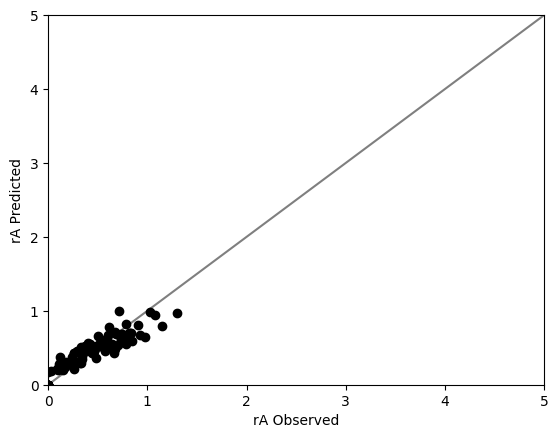

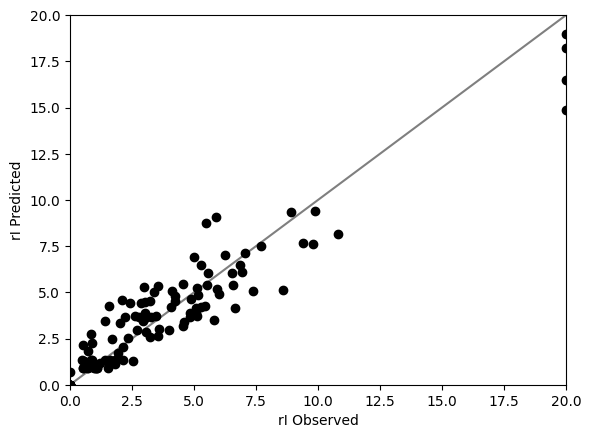

In [53]:

x_nar = np.zeros(110)
y_nar = np.zeros(110)
x_nir = np.zeros(110)
y_nir = np.zeros(110)
x = np.linspace(0,20,10)
y = np.linspace(0,20,10)
for native in range(10):
    for pert in range(11):
        x_nar[10*native + pert] = Y_CHL_NEG[native,pert, 0]
        x_nir[10*native + pert] = Y_CHL_NEG[native,pert, 1]
        y_nar[10*native + pert] = rA_grid[native, pert]
        y_nir[10*native + pert] = rI_grid[native, pert]
        
plt.scatter(x_nar, y_nar, color = 'Black')
plt.plot(x,y, color = 'Black', alpha = 0.5)
plt.xlabel('rA Observed')
plt.ylabel('rA Predicted')
plt.xlim(0,5)
plt.ylim(0,5)
plt.show()
plt.scatter(x_nir, y_nir, color = 'Black')
plt.plot(x,y, color = 'Black', alpha = 0.5)
plt.xlabel('rI Observed')
plt.ylabel('rI Predicted')
plt.xlim(0,20)
plt.ylim(0,20)
plt.show()
